# 强化学习 (policy gradient)

### 目标: 让智能体学会尽可能提高我们想要的动作的概率，降低我们不想要的动作的概率


### 例子：比如想要温度控制在50℃，智能体有升温和降温两个动作，那么当温度低于50时，智能体升温这个动作的概率要尽可能大；当温度高于50度时，智能体降温这个动作概率大

### 优化目标：$ L = A_t * logP_\theta(a_t|s_t) $

其中：1.$s_t$ 表示状态

2.$a_t$表示动作

3.$logP_\theta(a_t|s_t)$表示在状态$s_t$下，动作$a_t$的概率。比如，温度低于50度时，升温动作的概率

4.$A_t$表示当前这个动作的得分。比如，温度低于50度时，采取升温动作，是正确的，所以得分给个1分；如果采取降温动作那会给个-1分。从而告诉智能体温度低了需要升温。

## 二、优势函数
### 问题：我们在进行一个回合的游戏时，如果这个$A_t$都是只考虑了当前步骤，可能有点太局限了，每一步的动作都会影响接下来所有步骤，同时步骤离得越远，产生的影响也就越小。
### 于是我们可以将 $A_t = \sum_{k=0}^{T-t} r_{t+k}$，这表示当前t的优势得分等于当前步骤的得分加上以后所有步的得分，同时考虑到步骤离得越远，那么产生的影响越小，所以每一步都会乘以一个衰减系数$\gamma$，也就得到了$A_t = \sum_{k=0}^{T-t} \gamma^k r_{t+k}$


## 三、baseline

如图，左边这是三个动作的优势得分，因为动作的采样是存在概率，可能存在动作a没被采样到，数据只采样到了动作b和c，那么对于智能体而言就会提高动作b和c的概率分布，而动作a的概率分布就下降了。但是实际上a应该比c概率高才对，所以我们可以给优势函数减去一个价值期望，$A_t-baseline$然后动作c就会变成负的得分，就会降低动作c的概率，这更合理。

## 四、off-policy

因为强化学习里面，智能体每次跟环境互动后产生的一组数据会更新一次模型，那么旧的数据不属于新模型产生的策略，理论上不能复用，需要重新采样，那么就会导致重复进行采样数据和训练模型，会很慢。所以思考能否采样大量数据，先进行大量训练，再进行下一轮的数据采样呢，目的是加快训练。

### 重要性采样

$E_{x\sim p}[f(x)]\approx \frac{1}{N}\sum^N_{i=1}f(x^i),\color{red}{大数定律},当N趋向于无穷大时，等式成立$

分布p的期望可以约等于从分布p进行大量采样后的数据的均值，但是目前我们无法直接从分布p进行采样，所以需要变形

原式=$\int f(x)p(x)dx=\int f(x)\frac{p(x)}{q(x)}q(x)dx=E_{x\sim q}[f(x)\frac{p(x)}{q(x)}]\approx \frac{1}{N}\sum^N_{i=1}f(x^i)\frac{p(x^i)}{q(x^i)}$


重要性采样可以保证采样数据的期望大致上符合分布p,但是还有方差的偏差问题,方差公式:

$Var_{x\sim p}[x]=E_{x\sim p}[x^2]-(E_{x\sim p}[x])^2$

$Var_{x\sim p}[f(x)]=E_{x\sim p}[f(x)^2]-(E_{x\sim p}[f(x)])^2$

$Var_{x\sim q}[f(x)\frac{p(x)}{q(x)}]=E_{x\sim q}[(f(x)\frac{p(x)}{q(x)})^2]-(E_{x\sim q}[f(x)\frac{p(x)}{q(x)}])^2=E_{x\sim p}[f(x)^2\frac{p(x)}{q(x)}]-(E_{x\sim p}[f(x)])^2$

所以需要约束两个分布之间差距不能过大

## 五、clip

上面说到，重要性采样可以复用旧模型采样的数据，但是新旧模型分布不能差距太大，否则方差过大训练的数据没有意义了。我们希望约束两个分布，ppo提出的做法是：

$
L^{CLIP}(\theta) = \hat{\mathbb{E}}_t \left[ \min \left( r_t(\theta) \hat{A}_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon) \hat{A}_t \right) \right]
$,

其中$r_t(\theta) = \frac{p_\theta(a_t | s_t)}{q_{\theta_{\text{old}}}(a_t | s_t)}$,这个公式分A>0和A<0的情况，当A大于0时，我们希望$p$越大越好，但是如果$p$过大就会导致$\frac{p}{q}$过大，导致没有意义，这时我们需要clip给定一个上限的值，不能超过$1+\epsilon$，保证训练有意义；当A小于0时，同理我们希望越小越好，但是不能过小导致没意义，同样需要一个clip保证有下限$1-\epsilon$


## $\color{red}{任务说明：强化学习任务 - 控制小车运动}$
1. 任务背景
本任务是一个简化的强化学习控制问题，我们通过自定义一个环境，去控制一个一维的小车，使其尽量保持在中心位置。目标是让智能体学习如何通过选择加速或减速动作来控制小车的位置，最大化其在回合内的累计奖励。

2. 环境说明
这个环境的目标是使小车的当前位置尽量接近 0。智能体可以根据环境给出的状态（位置、速度）选择两种可能的动作：

动作 0：加速（增加小车的速度）
动作 1：减速（减少小车的速度）
3. 状态空间
智能体的状态由以下两个变量组成：

位置（Position）：小车在一维空间中的位置，范围是 [-5, 5]。0 代表小车在中心位置。
速度（Velocity）：小车的速度，范围是 [-1, 1]。负值表示向左移动，正值表示向右移动。
因此，状态空间是一个二维空间，包含小车的当前位置和速度。

4. 动作空间
智能体的动作空间只有两个离散动作：

动作 0：加速小车（增加速度）。
动作 1：减速小车（减小速度）。
5. 奖励函数
奖励函数设计的目标是让智能体尽量让小车保持在位置 0 附近，因此：

奖励为 负的绝对位置值，即 -abs(position)。
例如：当小车位于 0 时，奖励为 0；当小车位于 5 或 -5 时，奖励为 -5。
这样，智能体的目标是最大化每回合的累计奖励，奖励越接近 0 越好。

6. 结束条件
每个回合的最大步数为 200 步。如果在这个过程中小车运行超过最大步数，或者智能体成功地将小车控制到目标位置（不过本任务并没有设置目标位置）。每次步数达到上限，当前回合会结束。

#导入相关库

In [39]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
from torch.distributions import Categorical
from tqdm import tqdm


# 自定义简单环境

In [40]:
class SimpleEnv:
    def __init__(self, max_steps=200, max_position=5, max_velocity=1):
        self.max_steps = max_steps
        self.max_position = max_position
        self.max_velocity = max_velocity
        self.reset()

    def reset(self):
        self.position = np.random.uniform(-self.max_position, self.max_position)
        self.velocity = np.random.uniform(-self.max_velocity, self.max_velocity)
        self.steps = 0
        return np.array([self.position, self.velocity])

    def step(self, action):
        # 动作空间：0表示加速，1表示减速
        if action == 0:
            self.velocity += 0.1  # 加速
        elif action == 1:
            self.velocity -= 0.1  # 减速

        # 状态更新
        self.position += self.velocity
        self.position = np.clip(self.position, -self.max_position, self.max_position)
        self.velocity = np.clip(self.velocity, -self.max_velocity, self.max_velocity)

        # 奖励：尽量使位置保持在 0 附近
        reward = -abs(self.position)

        # 结束条件
        done = self.steps >= self.max_steps
        self.steps += 1

        return np.array([self.position, self.velocity]), reward, done, {}

# 定义PPO模型

In [41]:

class Actor(nn.Module):
    def __init__(self, obs_size, act_size):
        super(Actor, self).__init__()
        self.actor_net = nn.Sequential(
            nn.Linear(obs_size, 64),  # 全连接层，输入为obs_size，输出为64
            nn.ReLU(),  # ReLU激活函数
            nn.Linear(64, 64),  # 全连接层，输入为64，输出为64
            nn.ReLU(),  # ReLU激活函数
            nn.Linear(64, act_size),  # 全连接层，输入为64，输出为act_size
            nn.Softmax(dim=-1)  # Softmax激活函数，dim=-1表示对最后一个维度进行Softmax
        )

    def forward(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        return self.actor_net(x)

# PPO算法

In [92]:

class PPO:
    def __init__(self, input_dim, output_dim, lr, gamma, clip_ratio):
        self.actor = Actor(input_dim, output_dim)
        self.optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.gamma = gamma # 定义折扣因子
        self.clip_ratio = clip_ratio # 定义PPO中的超参数

    def update(self, rollouts):
        obs, act, rew, logp_old, val_old = rollouts[:5]
        # 计算returns
        returns = np.zeros_like(rew)
        for t in reversed(range(len(rew))):
          if t == len(rew) - 1:
            returns[t] = rew[t]
          else:
            returns[t] = rew[t] + self.gamma * returns[t+1]
        adv = returns - np.mean(returns)
        # adv = returns
        # 计算旧策略的动作概率和对数概率
        act = torch.tensor(act).long()
        logp_old = torch.tensor(logp_old).float()
        pi_old = self.actor(torch.tensor(obs).float()).gather(1, act.unsqueeze(-1)).squeeze(-1)
        ratio = torch.exp(torch.log(pi_old) - logp_old)
        surr1 = ratio * torch.from_numpy(adv).float()
        surr2 = torch.clamp(ratio, 1 - self.clip_ratio, 1 + self.clip_ratio) * torch.from_numpy(adv).float()
        actor_loss = -torch.min(surr1, surr2).mean()

        # 总损失
        loss = actor_loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 定义训练函数

In [93]:
def train(env, epochs, steps_per_epoch, steps, lr, gamma, clip_ratio):
    obs_size = 2  # 状态空间维度
    act_size = 2  # 动作空间维度：加速或减速
    ppo = PPO(obs_size, act_size, lr, gamma, clip_ratio)
    ep_reward_ans = []
    ep_reward = deque(maxlen=10)
    print('Started!')

    # 使用 tqdm 包装 epochs 的循环并创建 tqdm 实例
    with tqdm(range(epochs), desc="Training Progress") as pbar:
        for epoch in pbar:
            # 初始化缓冲区
            obs_buf, act_buf, rew_buf, logp_buf = [], [], [], []
            for _ in range(steps_per_epoch):
              obs = env.reset()
              ep_reward.append(0)
              for t in range(steps):
                  probs = ppo.actor(torch.tensor(obs).float())
                  m = Categorical(probs)
                  act = m.sample()
                  logp = m.log_prob(act)
                  obs_buf.append(obs)
                  act_buf.append(act.item())
                  rew_buf.append(0)
                  logp_buf.append(logp.item())

                  next_obs, rew, done, _ = env.step(act.item())
                  ep_reward[-1] += rew
                  rew_buf[-1] += rew
                  obs = next_obs
                  if done:
                      break
              ppo.update((obs_buf, act_buf, rew_buf, logp_buf, np.zeros_like(rew_buf)))

            # 更新 tqdm 的显示信息
            avg_reward = np.mean(ep_reward)
            ep_reward.append(avg_reward)
            if epoch % 5 == 0:
              ep_reward_ans.append(avg_reward)  # 将当前 epoch 的奖励加入结果，后续画图

            # 格式化字符串并更新 tqdm 描述
            avg_reward_str = f"{avg_reward:.2f}"
            pbar.set_postfix({'Epoch': epoch, 'Avg Reward': avg_reward_str})

    return ppo, ep_reward_ans

# 训练模型

In [94]:
env = SimpleEnv(max_steps=200)
ppo1, ep_reward1 = train(env, epochs=200, steps_per_epoch=5, steps=200, lr=0.002, gamma=0.99, clip_ratio=0.2)

Started!


Training Progress:   0%|          | 0/200 [00:00<?, ?it/s]<ipython-input-41-b0305ef344c3>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
Training Progress: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s, Epoch=199, Avg Reward=-46.43]


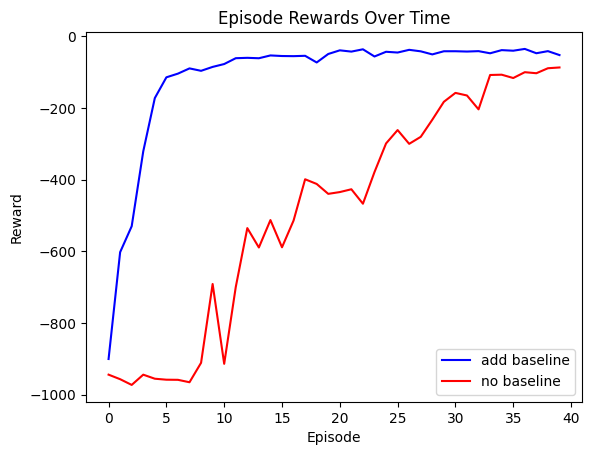

In [95]:
import matplotlib.pyplot as plt

# 创建一个折线图
plt.plot(ep_reward1, linestyle='-', color='b', label='add baseline')
plt.plot(ep_reward, linestyle='-', color='r', label='no baseline')
# 添加标题和标签
plt.title('Episode Rewards Over Time')  # 图表标题
plt.xlabel('Episode')  # x 轴标签
plt.ylabel('Reward')  # y 轴标签

# 显示图例
plt.legend()

# 显示图形
plt.show()


# 测试函数

In [96]:

def test(ppo, episodes=10):
    total_rewards = []

    for episode in range(episodes):
        obs = env.reset()  # 重置环境
        done = False
        total_reward = 0
        while not done:
            # 使用训练好的模型进行推理
            probs = ppo.actor(torch.tensor(obs).float())
            m = Categorical(probs)
            action = m.sample().item()  # 选择动作

            # 执行动作并获得新的状态和奖励
            next_obs, reward, done, _ = env.step(action)
            total_reward += reward
            obs = next_obs

        total_rewards.append(total_reward)
        print(f"Episode {episode + 1}, Total Reward: {total_reward}, obs: {next_obs}")

    avg_reward = np.mean(total_rewards)
    print(f"Average Reward over {episodes} episodes: {avg_reward}")

In [97]:
test(ppo, episodes=10)

<ipython-input-41-b0305ef344c3>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Episode 1, Total Reward: -61.75450398754556, obs: [ 0.0676112  -0.01138931]
Episode 2, Total Reward: -72.84878754036698, obs: [0.16867077 0.11390204]
Episode 3, Total Reward: -51.82354549398664, obs: [0.27601738 0.07988336]
Episode 4, Total Reward: -127.80043525716626, obs: [-0.33890827  0.01629429]
Episode 5, Total Reward: -89.66751492360555, obs: [ 0.01566271 -0.17220256]
Episode 6, Total Reward: -143.26667821038657, obs: [-0.59429087 -0.04069222]
Episode 7, Total Reward: -55.32137722281429, obs: [-0.47702712  0.10329906]
Episode 8, Total Reward: -114.75325052233964, obs: [ 0.3334471  -0.06995668]
Episode 9, Total Reward: -103.1356069572725, obs: [-0.02667831 -0.0701989 ]
Episode 10, Total Reward: -58.09818982417727, obs: [-0.37898897 -0.06022502]
Average Reward over 10 episodes: -87.84698899396612


In [98]:
test(ppo1, episodes=10)

<ipython-input-41-b0305ef344c3>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Episode 1, Total Reward: -37.83926487878607, obs: [-0.08203407  0.03541204]
Episode 2, Total Reward: -38.05832048925164, obs: [-0.04775611  0.00545165]
Episode 3, Total Reward: -29.183767334483207, obs: [-0.195358   -0.02334116]
Episode 4, Total Reward: -29.167359388331857, obs: [-0.0891137  -0.00467287]
Episode 5, Total Reward: -65.29689047196044, obs: [-0.16902342  0.03985415]
Episode 6, Total Reward: -60.5206387106792, obs: [-0.30312903 -0.05435737]
Episode 7, Total Reward: -36.99264489784989, obs: [ 0.07216278 -0.00741559]
Episode 8, Total Reward: -32.38433372554307, obs: [-0.22527829 -0.13060132]
Episode 9, Total Reward: -101.23051231640753, obs: [-0.15257289 -0.04975298]
Episode 10, Total Reward: -97.73029856434782, obs: [-0.24836082 -0.04481016]
Average Reward over 10 episodes: -52.84040307776407
